In [1]:
from scipy.stats import multivariate_normal
import pybnb
%load_ext autoreload
%autoreload 2

from BranchAndBoundSolver import BranchAndBoundSolver

In [60]:
training_points = multivariate_normal.rvs(size=(15,2))
point_to_be_classified = training_points[0]
problem = BranchAndBoundSolver(training_points, point_to_be_classified)
solver = pybnb.Solver(comm=None)
results = solver.solve(problem)

solve begins
Starting branch & bound solve:
 - dispatcher pid: 30808 (MacBook-Pro.fritz.box)
 - worker processes: 1
--------------------------------------------------------------------------------------------------------------------------
         Nodes        |                      Objective Bounds                       |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap         Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%             inf |      0.0       0.00     0.00%      0
*        1         3  |      0.9446781      0.06297854   88.169956%    0.8816995594 |      0.0     351.75     0.00%      0
*        2         5  |      0.9126655      0.06297854   84.968697%    0.8496869655 |      0.0     538.51     0.00%      0
*     3925      4082  |      0.8972408        0.294296   60.294482%    0.6029448237 |      0.9    3241.96     0.00%      0
*     4156      3771  |     

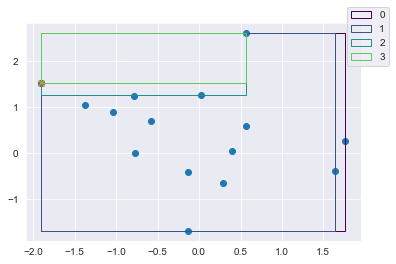

In [61]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
cmap = plt.colormaps['viridis']
def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=index
    )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x")
ax = plt.gca()
total = len(problem.trajectory)
for i, interval in enumerate(problem.trajectory):
    draw2dpattern(interval, ax, i, total)
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()
